<a href="https://colab.research.google.com/github/nmermigas/GCDB/blob/main/CalendAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Imports

In [2]:
import torch
import torchvision
import requests
import zipfile
import matplotlib.pyplot as plt
import copy

from pathlib import Path
from torch import nn
from torchvision import datasets,transforms

import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 1. Setting up device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Get data

### 2.1 The GCDB dataset
- contains data from handwritten letters in Greek, both uppercase and lowercase.

In [1]:
data_path=Path('data/')
gcdb_path = data_path / 'gcdb'

if gcdb_path.is_dir():
  print(f'{gcdb_path} directory exists')
else:
  print(f"Did not find {gcdb_path} directory, creating one...")
  gcdb_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "gcdb.zip", "wb") as f:
      request = requests.get("https://github.com/nmermigas/GCDB/raw/main/gcdb.zip")
      print("Downloading gcdb data...")
      f.write(request.content)
  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "gcdb.zip", "r") as zip_ref:
      print("Unzipping gcdb data...")
      zip_ref.extractall(gcdb_path)


Did not find data/gcdb directory, creating one...
Unzipping gcdb data...


In [ ]:
sd

Creating train and test datasets out of the GCDB dataset.
Seeing the structure of the folder we downloaded, the data format is the one below:

    gcdb/
      Query/
        LETT_CAP_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...











For each of the 24 letters of the greek alphabet, there are two folders for its uppercase and 2 folders for its lowercase version.

Each folder contains `bmp` images.




Our goal is to create the following structure:


    gcdb/
      train/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
        ...
      test/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
          ...
        ...



So basically, combine the uppercase and the lowercase data for each letter into one and then split them into train and test folders.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`




In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(gcdb_path)


There are 1 directories and 0 images in 'data/gcdb'.
There are 96 directories and 0 images in 'data/gcdb/Query'.
There are 0 directories and 457 images in 'data/gcdb/Query/LETT_SML_NORM.THETA'.
There are 0 directories and 445 images in 'data/gcdb/Query/LETT_SML_SUFF.TAU'.
There are 0 directories and 453 images in 'data/gcdb/Query/LETT_SML_NORM.DELTA'.
There are 0 directories and 422 images in 'data/gcdb/Query/LETT_SML_SUFF.NI'.
There are 0 directories and 451 images in 'data/gcdb/Query/LETT_CAP_SUFF.OMEGA'.
There are 0 directories and 444 images in 'data/gcdb/Query/LETT_CAP_NORM.IOTA'.
There are 0 directories and 454 images in 'data/gcdb/Query/LETT_CAP_NORM.FI'.
There are 0 directories and 430 images in 'data/gcdb/Query/LETT_SML_NORM.TAU'.
There are 0 directories and 456 images in 'data/gcdb/Query/LETT_CAP_NORM.HETA'.
There are 0 directories and 448 images in 'data/gcdb/Query/LETT_SML_SUFF.KAPA'.
There are 0 directories and 446 images in 'data/gcdb/Query/LETT_CAP_NORM.TAU'.
There are 0

It looks like we have 96 directories (4 directories * 24 letters) with each containing roughly 430 images.

Now let's combine the data for each letter.


In [23]:
import os
import shutil
import random

# Define the paths
source_dir = "data/gcdb/Query"
target_dir = "data/gcdb_combined"

# Create target directories for train and test sets
train_dir = os.path.join(target_dir, "train")
test_dir = os.path.join(target_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split images into train and test sets
def split_images(images, train_ratio):
    random.shuffle(images)
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]
    return train_images, test_images

# Iterate through the directories
for root, dirs, files in os.walk(source_dir):
    for dir_name in dirs:
        letter = dir_name.split(".")[1]  # Extract the letter (ALPHA, BETA, etc.)
        uppercase_images = []
        lowercase_images = []

        # Gather uppercase and lowercase images
        for variation in ["NORM", "SUFF"]:
            uppercase_dir = os.path.join(root, f"LETT_CAP_{variation}.{letter}")
            lowercase_dir = os.path.join(root, f"LETT_SML_{variation}.{letter}")
            if os.path.exists(uppercase_dir):
                uppercase_images.extend(os.listdir(uppercase_dir))
            if os.path.exists(lowercase_dir):
                lowercase_images.extend(os.listdir(lowercase_dir))

        # Split images into train and test sets
        train_uppercase, test_uppercase = split_images(uppercase_images, train_ratio=0.8)
        train_lowercase, test_lowercase = split_images(lowercase_images, train_ratio=0.8)

        # Create directories for the letter in train and test sets
        os.makedirs(os.path.join(train_dir, "uppercase", letter), exist_ok=True)
        os.makedirs(os.path.join(train_dir, "lowercase", letter), exist_ok=True)
        os.makedirs(os.path.join(test_dir, "uppercase", letter), exist_ok=True)
        os.makedirs(os.path.join(test_dir, "lowercase", letter), exist_ok=True)

        # Copy images to train and test directories
        for image in train_uppercase:
            src = os.path.join(root, f"LETT_CAP_NORM.{letter}", image)
            dst = os.path.join(train_dir, "uppercase", letter, image)
            shutil.copy(src, dst)
        for image in train_lowercase:
            src = os.path.join(root, f"LETT_SML_NORM.{letter}", image)
            dst = os.path.join(train_dir, "lowercase", letter, image)
            shutil.copy(src, dst)
        for image in test_uppercase:
            src = os.path.join(root, f"LETT_CAP_NORM.{letter}", image)
            dst = os.path.join(test_dir, "uppercase", letter, image)
            shutil.copy(src, dst)
        for image in test_lowercase:
            src = os.path.join(root, f"LETT_SML_NORM.{letter}", image)
            dst = os.path.join(test_dir, "lowercase", letter, image)
            shutil.copy(src, dst)


FileNotFoundError: [Errno 2] No such file or directory: 'data/gcdb/Query/LETT_CAP_NORM.THETA/form_287.bmp'

In [21]:
source_dir = "data/gcdb/Query"
for root, dirs, files in os.walk(source_dir):
    for dir_name in dirs:
        letter = dir_name.split(".")[1]  # Extract the letter (ALPHA, BETA, etc.)
        uppercase_images = []
        lowercase_images = []
            # Gather uppercase and lowercase images
        for variation in ["NORM", "SUFF"]:
            uppercase_dir = os.path.join(root, f"LETT_CAP_{variation}.{letter}")
            lowercase_dir = os.path.join(root, f"LETT_SML_{variation}.{letter}")
            if os.path.exists(uppercase_dir):
                uppercase_images.extend(os.listdir(uppercase_dir))
            if os.path.exists(lowercase_dir):
                lowercase_images.extend(os.listdir(lowercase_dir))

        train_uppercase, test_uppercase = split_images(uppercase_images, train_ratio=0.8)
        train_lowercase, test_lowercase = split_images(lowercase_images, train_ratio=0.8)

        os.makedirs(os.path.join(train_dir, "uppercase", letter), exist_ok=True)
        os.makedirs(os.path.join(train_dir, "lowercase", letter), exist_ok=True)
        os.makedirs(os.path.join(test_dir, "uppercase", letter), exist_ok=True)
        os.makedirs(os.path.join(test_dir, "lowercase", letter), exist_ok=True)


THETA
TAU
DELTA
NI
OMEGA
IOTA
FI
TAU
HETA
KAPA
TAU
OMIKRON
MI
FI
LAMDA
XI
GAMMA
XI
LAMDA
YPSILON
KAPA
DELTA
NI
HETA
ALPHA
YPSILON
NI
EPSILON
THETA
RO
SIGMA
EPSILON
PII
OMIKRON
EPSILON
PII
THETA
KSI
DELTA
PSI
PSI
ALPHA
OMEGA
YPSILON
KAPA
OMEGA
NI
PII
OMIKRON
XI
ALPHA
KSI
ALPHA
HETA
IOTA
RO
KSI
SIGMA
MI
YPSILON
PSI
OMIKRON
ZETA
THETA
LAMDA
HETA
ZETA
PSI
PII
XI
TAU
FI
BETA
GAMMA
BETA
MI
KSI
GAMMA
IOTA
SIGMA
KAPA
FI
GAMMA
BETA
RO
IOTA
MI
SIGMA
RO
BETA
ZETA
DELTA
OMEGA
ZETA
EPSILON
LAMDA


In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
import copy

from torch import nn
from torchvision import datasets,transforms
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

data_dir = Path('data')

# emnist_train_transforms = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
# ])

# Get EMNIST training data
emnist_data = datasets.EMNIST(root=data_dir,
                                       split='letters',
                                       train= True,
                                       download = True)

# emnist_test_data = datasets.EMNIST(root=data_dir,
#                                    split='balanced',
#                                    train=False,
#                                    download=True)


 20%|█▉        | 109740032/561753746 [00:03<00:15, 29166968.52it/s]


KeyboardInterrupt: 

In [ ]:
print(f'Data size: {emnist_data.data.shape}')

images = emnist_data.data.view([emnist_data.data.shape[0],1,emnist_data.data.shape[1],emnist_data.data.shape[2]]).float()

print(f'Tensor data: {images.shape}')

Data size: torch.Size([124800, 28, 28])
Tensor data: torch.Size([124800, 1, 28, 28])


In [ ]:
emnist_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
letterCategories = emnist_data.classes[1:]
labels = copy.deepcopy(emnist_data.targets)-1
print(labels.shape)

torch.Size([124800])


In [ ]:
labels.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

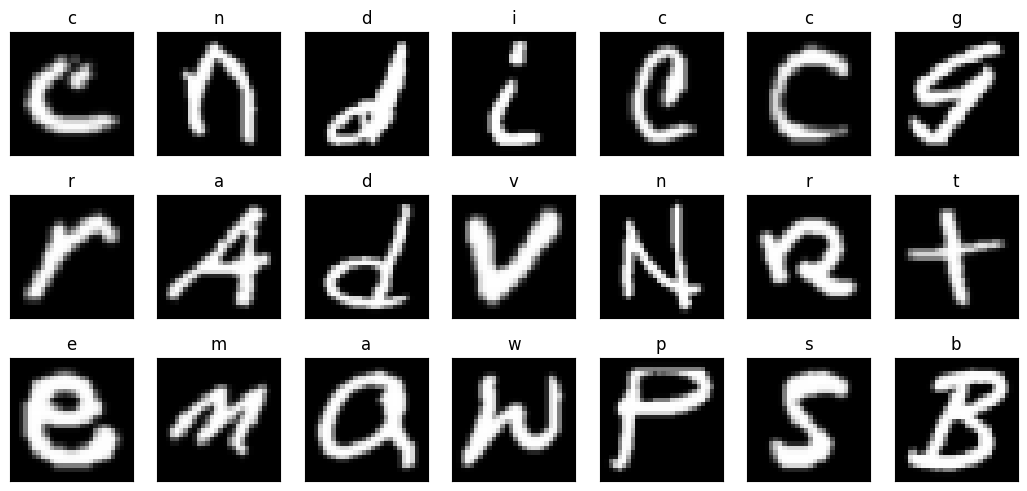

In [ ]:
# visualize

fig, axs = plt.subplots(3,7, figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
  pic = np.random.randint(images.shape[0])

  image = np.squeeze(images[pic,:,:])
  letter = letterCategories[labels[pic]]

  ax.imshow(image.T,cmap='gray')
  ax.set_title(f"{letter}")
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

### Create train/test sets

In [ ]:
import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

num_workers = os.cpu_count()
print(num_workers)

train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
train_data = TensorDataset(test_data,test_labels)

batch_size = 32
train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True)


2


In [ ]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cce096f5930>,
 <torch.utils.data.dataloader.DataLoader at 0x7cce096f5900>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
print(train_dataloader.dataset.tensors[0].shape)
print(train_dataloader.dataset.tensors[1].shape)


torch.Size([12480, 1, 28, 28])
torch.Size([12480])
